# Lab 8: Regression

Welcome to Lab 8! This lab is due **Thursday 6/3 at 11:59pm**.

Today we will get some hands-on practice with linear regression. You can find more information about this topic in
[Section 16](https://www.inferentialthinking.com/chapters/16/Inference_for_Regression.html).

In [1]:
import numpy as np
import babypandas as bpd
import math

# These lines set up graphing capabilities.
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import otter
grader = otter.Notebook()

# 1. How Faithful is Old Faithful? 

(Note: clever title comes from [here](http://web.pdx.edu/~jfreder/M212/oldfaithful.pdf).)

Old Faithful is a geyser in Yellowstone National Park in the central United States.  It's famous for erupting on a fairly regular schedule.  You can see a video below.

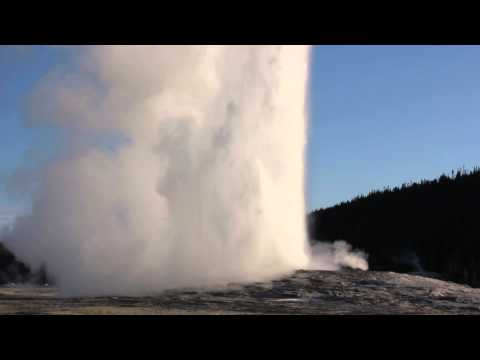

In [2]:
# For the curious: this is how to display a YouTube video in a
# Jupyter notebook.  The argument to YouTubeVideo is the part
# of the URL (called a "query parameter") that identifies the
# video.  For example, the full URL for this video is:
#   https://www.youtube.com/watch?v=wE8NDuzt8eg
from IPython.display import YouTubeVideo
YouTubeVideo("wE8NDuzt8eg")

Some of Old Faithful's eruptions last longer than others.  When it has a long eruption, there's generally a longer wait until the next eruption.

If you visit Yellowstone, you might want to predict when the next eruption will happen, so you can see the rest of the park and come to see the geyser when it happens.  Today, we will use a dataset on eruption durations and waiting times to see if we can make such predictions accurately with linear regression.

The dataset has one row for each observed eruption.  It includes the following columns:
- **`duration`**: Eruption duration, in minutes
- **`wait`**: Time between this eruption and the next, also in minutes

Run the next cell to load the dataset.

In [3]:
faithful = bpd.read_csv("data/faithful.csv")
faithful

,duration,wait
0,3.600,79.0
1,1.800,54.0
2,3.333,74.0
3,2.283,62.0
4,4.533,85.0
...,...,...
267,4.117,81.0
268,2.150,46.0
269,4.417,90.0
270,1.817,46.0


We would like to use linear regression to make predictions, but that won't work well if the data aren't roughly linearly related.  To check that, we should look at the data.

**Question 1.1**
Make a scatter plot of the data.  It's conventional to put the column we will try to predict on the **vertical axis** and the other column on the horizontal axis.

***Hint***: You may want to refer to the Matplotlib documentation for [scatter](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html)

<AxesSubplot:xlabel='duration', ylabel='wait'>

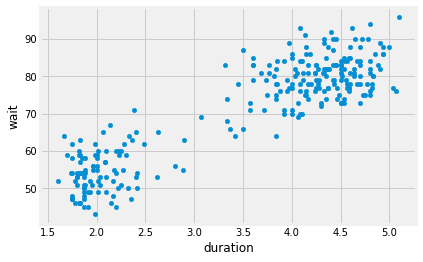

In [4]:
faithful.plot(kind='scatter', y='wait', x='duration')

**Question 1.2**
Look at the scatter plot. Are eruption duration and waiting time roughly linearly related?  If so, is the relationship negative or positive?  You may want to consult the textbook's [Chapter 15](https://www.inferentialthinking.com/chapters/15/Prediction.html) for the definition of "linearly related."  Assign either 1, 2, 3, or 4 to the variable `faith_q2` below. 
1. Eruption duration and waiting time are not roughly linearly related.
2. Eruption duration and waiting time are roughly linearly related, the relationship between them is flat (no relationship).
3. Eruption duration and waiting time are roughly linearly related, the relationship between them is negative.
4. Eruption duration and waiting time are roughly linearly related, the relationship between them is positive.

In [5]:
faith_q2 = 4

In [6]:
grader.check("q12")

q12 passed!

We're going to continue with the provisional assumption that they are linearly related, so it's reasonable to use linear regression to analyze this data.

Next, we'd like to plot the data in standard units.  Recall that, if `nums` is an array of numbers, then

`(nums - np.mean(nums)) / np.std(nums)`

is an array of those numbers in standard units.

**Question 1.3**
Compute the mean and standard deviation of the eruption durations and waiting times.  **Then** create a table called `faithful_standard` containing the eruption durations and waiting times in standard units.  (The columns should be named "`duration (standard units)`" and "`wait (standard units)`".

You may also want to convert Series into Numpy arrays using `to_numpy()`. 

In [7]:
durations =  faithful.get('duration').values
duration_mean = durations.mean()
duration_std = np.std(durations)
waits = faithful.get('wait').values
wait_mean = waits.mean()
wait_std =  np.std(waits)

faithful_standard = bpd.DataFrame(data = {
    'duration (standard units)': (durations - duration_mean) / duration_std ,
    'wait (standard units)': (waits - wait_mean) / wait_std
})
faithful_standard

,duration (standard units),wait (standard units)
0,0.098499,0.597123
1,-1.481459,-1.245181
2,-0.135861,0.228663
3,-1.057503,-0.655644
4,0.917443,1.039277
...,...,...
267,0.552298,0.744508
268,-1.174245,-1.834719
269,0.815624,1.407737
270,-1.466537,-1.834719


In [8]:
grader.check("q13")

q13 passed!

**Question 1.4**
Plot the data again, but this time in standard units.

<AxesSubplot:xlabel='duration (standard units)', ylabel='wait (standard units)'>

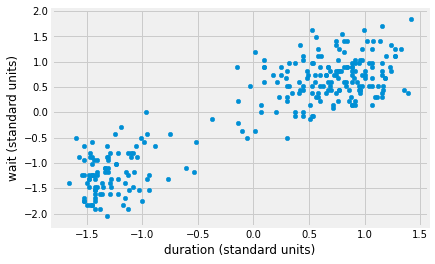

In [9]:
faithful_standard.plot(kind='scatter', y='wait (standard units)', x='duration (standard units)')

You'll notice that this plot looks exactly the same as the last one!  The data really are different, but the axes are scaled differently.  (The method `scatter` scales the axes so the data fill up the available space.)  So it's important to read the ticks on the axes.

**Question 1.5**
Among the following numbers, which would you guess is closest to the correlation between eruption duration and waiting time in this dataset?

* -1
* 0
* 1

In [10]:
correlation_guess = 1

In [11]:
grader.check("q15")

q15 passed!

**Question 1.6**
Compute the correlation `r`.  

*Hint:* Use `faithful_standard`.  Section [15.1](https://www.inferentialthinking.com/chapters/15/1/Correlation.html) explains how to do this.

In [12]:
r = (faithful_standard.get('wait (standard units)') * faithful_standard.get('duration (standard units)')).mean()
r

0.9008111683218132

In [13]:
grader.check("q16")

q16 passed!

## 2. The regression line
Recall that the correlation is the *slope* of the regression line when the data are put in standard units.

The next cell plots the **regression line in standard units**:

$$\text{waiting time (standard units)} = r \times \text{eruption duration (standard units)}.$$

Then, it overlaps the line on a plot of the original data (in standard units) for comparison.  (You don't need to fully understand the code, **just run it**.)

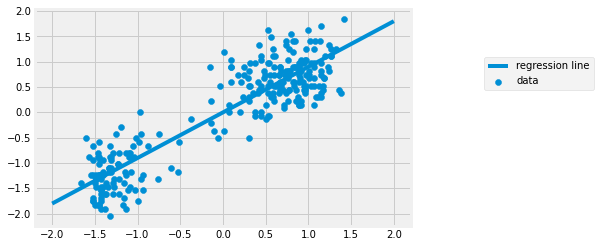

In [14]:
def plot_data_and_line(dataset, x, y, point_0, point_1):
    """Makes a scatter plot of the dataset, along with a line passing through two points."""
    plt.scatter(x = dataset.get(x), y = dataset.get(y), label = 'data')
    xs, ys = zip(point_0, point_1)
    plt.plot(xs, ys, label="regression line")
    plt.legend(bbox_to_anchor=(1.5,.8))

plot_data_and_line(faithful_standard, 
                   "duration (standard units)", 
                   "wait (standard units)", 
                   [-2, -2*r], 
                   [2, 2*r])

How would you take a point in standard units and convert it back to original units?  We'd have to "stretch" its horizontal position by `duration_std` and its vertical position by `wait_std`.

That means the same thing would happen to the slope of the line.

Stretching a line horizontally makes it less steep, so we divide the slope by the stretching factor.  Stretching a line vertically makes it more steep, so we multiply the slope by the stretching factor.

**Question 2.1**
What is the slope of the regression line in original units?

***Hint***: If the "stretching" explanation is unintuitive, consult section [15.2](https://www.inferentialthinking.com/chapters/15/2/Regression_Line.html) in the textbook.

In [15]:
slope = r * wait_std / duration_std
slope

10.729641395133529

We know that the regression line passes through the point `(duration_mean, wait_mean)`.  You might recall from high-school algebra that the equation for the line is therefore:

$$\text{waiting time} - \verb|wait_mean| = \texttt{slope} \times (\text{eruption duration} - \verb|duration_mean|)$$

After rearranging that equation slightly, the intercept turns out to be:

In [16]:
intercept = wait_mean - (slope * duration_mean)
intercept

33.474397022753344

In [17]:
grader.check("q21")

q21 passed!

## 3. Investigating the regression line
The slope and intercept tell you exactly what the regression line looks like.  To predict the waiting time for an eruption, multiply the eruption's duration by `slope` and then add `intercept`.

**Question 3.1**
Compute the predicted waiting time for an eruption that lasts 2 minutes, and for an eruption that lasts 5 minutes.

In [18]:
two_minute_predicted_waiting_time = (2 * slope) + intercept
five_minute_predicted_waiting_time = (5 * slope) + intercept

# Here is a helper function to print out your predictions
# (you don't need to modify it):
def print_prediction(duration, predicted_waiting_time):
    print("After an eruption lasting", duration,
          "minutes, we predict you'll wait", predicted_waiting_time,
          "minutes until the next eruption.")

print_prediction(2, two_minute_predicted_waiting_time)
print_prediction(5, five_minute_predicted_waiting_time)

After an eruption lasting 2 minutes, we predict you'll wait 54.933679813020404 minutes until the next eruption.
After an eruption lasting 5 minutes, we predict you'll wait 87.12260399842098 minutes until the next eruption.


In [19]:
grader.check("q31")

q31 passed!

The next cell plots the line that goes between those two points, which is (a segment of) the regression line.

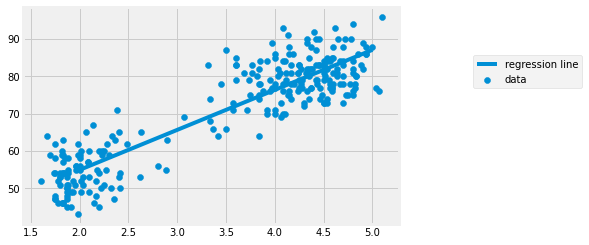

In [20]:
plot_data_and_line(faithful, "duration", "wait", 
                   [2, two_minute_predicted_waiting_time], 
                   [5, five_minute_predicted_waiting_time])

**Question 3.2**
Make predictions for the waiting time after each eruption in the `faithful` table.  (Of course, we know exactly what the waiting times were!  We are doing this so we can see how accurate our predictions are.)  Put these numbers into a column in a new table called `faithful_predictions`.  Its first row should look like this:

|duration|wait|predicted_wait|
|-|-|-|
|3.6|79|72.1011|

*Hint:* There is no need for a `for` loop; use array arithmetic instead.

In [21]:
faithful_predictions = faithful.assign(predicted_wait=(faithful.get('duration') * slope) + intercept)

faithful_predictions

,duration,wait,predicted_wait
0,3.600,79.0,72.101106
1,1.800,54.0,52.787752
2,3.333,74.0,69.236292
3,2.283,62.0,57.970168
4,4.533,85.0,82.111861
...,...,...,...
267,4.117,81.0,77.648331
268,2.150,46.0,56.543126
269,4.417,90.0,80.867223
270,1.817,46.0,52.970155


In [22]:
grader.check("q32")

q32 passed!

**Question 3.3**
How close were we?  Compute the *residual* for each eruption in the dataset.  The residual is the difference (not the absolute difference) between the actual waiting time and the predicted waiting time.  Add the residuals to `faithful_predictions` as a new column called "`residual`", naming the resulting table `faithful_residuals`.

*Hint:* Again, your code will be much simpler if you don't use a `for` loop.

In [23]:
faithful_residuals = faithful_predictions.assign(residual=faithful_predictions.get('wait') - faithful_predictions.get('predicted_wait'))
faithful_residuals

,duration,wait,predicted_wait,residual
0,3.600,79.0,72.101106,6.898894
1,1.800,54.0,52.787752,1.212248
2,3.333,74.0,69.236292,4.763708
3,2.283,62.0,57.970168,4.029832
4,4.533,85.0,82.111861,2.888139
...,...,...,...,...
267,4.117,81.0,77.648331,3.351669
268,2.150,46.0,56.543126,-10.543126
269,4.417,90.0,80.867223,9.132777
270,1.817,46.0,52.970155,-6.970155


In [24]:
grader.check("q33")

q33 passed!

Here is a plot of the residuals you computed.  Each point corresponds to one eruption.  It shows how much our prediction over- or under-estimated the waiting time.

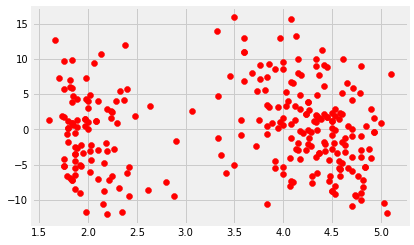

In [25]:
plt.scatter(x = faithful_residuals.get("duration"), y = faithful_residuals.get("residual"), color="r")

There isn't really a pattern in the residuals, which confirms that it was reasonable to try linear regression.  It's true that there are two separate clouds; the eruption durations seemed to fall into two distinct clusters.  But that's just a pattern in the eruption durations, not a pattern in the relationship between eruption durations and waiting times.

## 4. How accurate are different predictions?
Earlier, you should have found that the correlation is fairly close to 1, so the line fits fairly well on the training data.  That means the residuals are overall small (close to 0) in comparison to the waiting times.

We can see that visually by plotting the waiting times and residuals together:

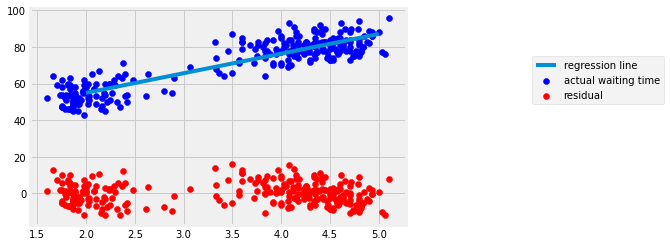

In [26]:
plt.scatter(x = faithful_residuals.get("duration"), y = faithful_residuals.get("wait"), label="actual waiting time", color="blue")
plt.scatter(faithful_residuals.get("duration"), faithful_residuals.get("residual"), label="residual", color="r")
plt.plot([2, 5], [two_minute_predicted_waiting_time, five_minute_predicted_waiting_time], label="regression line")
plt.legend(bbox_to_anchor=(1.7,.8));

However, unless you have a strong reason to believe that the linear regression model is true, you should be wary of applying your prediction model to data that are very different from the training data.

**Question 4.1** In `faithful`, no eruption lasted exactly 0, 2.5, or 60 minutes.  Using this line, what is the predicted waiting time for an eruption that lasts 0 minutes?  2.5 minutes?  An hour?

In [27]:
zero_minute_predicted_waiting_time = (0 * slope) + intercept
two_point_five_minute_predicted_waiting_time = (2.5 * slope) + intercept
hour_predicted_waiting_time = (60 * slope) + intercept

print_prediction(0, zero_minute_predicted_waiting_time)
print_prediction(2.5, two_point_five_minute_predicted_waiting_time)
print_prediction(60, hour_predicted_waiting_time)

After an eruption lasting 0 minutes, we predict you'll wait 33.474397022753344 minutes until the next eruption.
After an eruption lasting 2.5 minutes, we predict you'll wait 60.29850051058716 minutes until the next eruption.
After an eruption lasting 60 minutes, we predict you'll wait 677.252880730765 minutes until the next eruption.


In [28]:
grader.check("q41")

q41 passed!

**Question 4.2** Do you believe any of these values are reliable predictions?  Why or why not?
 
Assign `true_predictions` to a list of the correct statements.
1. The predicted waiting time for a zero minute duration is reliable.
2. The predicted waiting time for a 2.5 minute duration is reliable.
3. The predicted waiting time for an hour durationis reliable.
4. We have data for all of the durations we predicted waiting times for.
5. We have data surrounding (above and below) all of the durations we predicted waiting times for.

In [29]:
true_predictions = [2]

In [30]:
grader.check("q42")

q42 passed!

## 5. Divide and Conquer

It appears from the scatter diagram that there are two clusters of points: one for durations around 2 and another for durations between 3.5 and 5. A vertical line at 3 divides the two clusters.

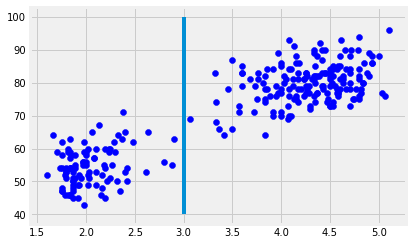

In [31]:
plt.scatter(x = faithful_residuals.get("duration"), y = faithful_residuals.get("wait"), label="actual waiting time", color="blue")
plt.plot([3, 3], [40, 100]);

The `standardize` function from lecture appears below, which returns a table of values in standard units.

In [32]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - (any_numbers.mean())) / np.std(any_numbers)  

def standardize(t):
    """Return a table in which all columns of t are converted to standard units."""
    t_su = t.assign(duration_standard=standard_units(t.get('duration')),
                wait_standard=standard_units(t.get('wait')))
    return t_su

**Question 5.1** Separately compute the regression coefficients, `r`, for all the points with a duration below 3, **and then** for all the points with a duration equal to or above 3. To do so, create a function that computes `r` from a table and pass it two different tables of points, `below_3` and `above_3`.

In [33]:
def reg_coeff(t):
    """Return the regression coefficient for columns 0 & 1."""
    t_su = standardize(t)
    r = np.mean((t_su.get("duration_standard") * t_su.get("wait_standard")).to_numpy())

    
    return r

below_3 = faithful[faithful.get('duration') < 3]
above_3 = faithful[faithful.get('duration') >= 3]

below_3_r = reg_coeff(below_3)
above_3_r =  reg_coeff(above_3)
print("For points below 3, r is", below_3_r, "; for points above 3, r is", above_3_r)

For points below 3, r is 0.2901895264925431 ; for points above 3, r is 0.37278222557075114


In [34]:
grader.check("q51")

q51 passed!

**Question 5.2** Write functions `slope_of` and `intercept_of` below. 

When you're done, the functions `wait_below_3` and `wait_above_3` should each use a different regression line to predict a wait time for a duration. The first function should use the regression line for all points with duration below 3. The second function should use the regression line for all points with duration above or equal to 3.

In [35]:
def slope_of(t, r):
    """Return the slope of the regression line for t in original units.
    
    Assume that column 0 of t contains x values and column 1 of t contains y values.
    r is the regression coefficient for x and y.
    """
    return r * np.std(t.get('wait')) / np.std(t.get('duration'))

def intercept_of(t, r):
    """Return the intercept of the regression line for t in original units."""
    s = slope_of(t, r)
    return t.get('wait').mean() - (s * t.get('duration').mean())
    
below_3_a = slope_of(below_3, below_3_r)
below_3_b = intercept_of(below_3, below_3_r)
above_3_a = slope_of(above_3, above_3_r)
above_3_b = intercept_of(above_3, above_3_r)

def wait_below_3(duration):
    return below_3_a * duration + below_3_b

def wait_above_3(duration):
    return above_3_a * duration + above_3_b

In [36]:
grader.check("q52")

q52 passed!

The plot below shows two different regression lines, one for each cluster!

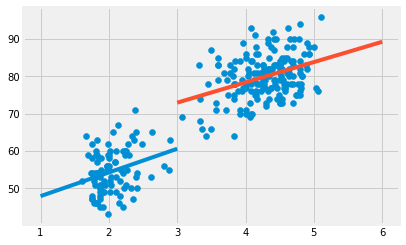

In [37]:
plt.scatter(x = faithful.get("duration"), y = faithful.get("wait"))
plt.plot([1, 3], [wait_below_3(1), wait_below_3(3)])
plt.plot([3, 6], [wait_above_3(3), wait_above_3(6)]);

**Question 5.3** Write a function `predict_wait` that takes a `duration` and returns the predicted wait time using the appropriate regression line, depending on whether the duration is below 3 or greater than or equal to 3.

In [38]:
def predict_wait(duration):
    """Return the wait predicted by the appropriate one of the two regression lines above."""
    if duration < 3:
        return wait_below_3(duration)
    else:
        return wait_above_3(duration)
            

In [39]:
grader.check("q53")

q53 passed!

The predicted wait times for each point appear below.

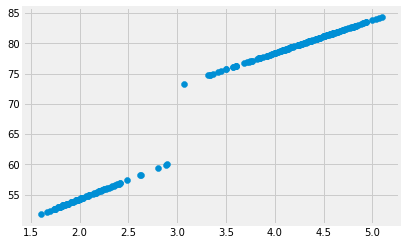

In [40]:
new_faithful = faithful.assign(predicted = faithful.get('duration').apply(predict_wait))
plt.scatter(new_faithful.get('duration'), new_faithful.get('predicted'))

**Question 5.4** Do you think the predictions produced by `predict_wait` would be more or less accurate than the predictions from the regression line you created in section 2? How could you tell?

To answer this question, let's create another plot of the residuals, this time from `new_faithful`, and see if they're any different than before.  Make an array of new residuals from the predictions in `new_faithful` and assign it to the name `new_residuals`.

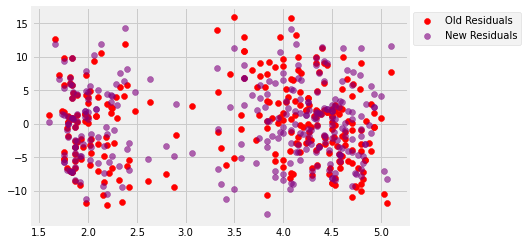

In [41]:
new_residuals = np.array(new_faithful.get('wait') - new_faithful.get('predicted'))
plt.scatter(faithful_residuals.get('duration'), faithful_residuals.get('residual'),
              c='r', label='Old Residuals')
plt.scatter(new_faithful.get('duration'), new_residuals, c='purple', label='New Residuals', alpha=0.6)
plt.legend(bbox_to_anchor=(1, 1))

Now that we have plotted the residuals, can we say that the new set of predictions are more or less accurate than before?  Assign either 1, 2, 3, or 4 to the variable `new_predict` below.
1. The new predictions are more accurate than the old predictions because the new residuals have a lower max value than the old residuals, as well as a lower minimum value than the old residuals, so the new predictions are closer to the true values than the old predictions.
2. The new predictions are more accurate than the old predictions because the new residuals exhibit less spread than the old residuals, so the new predictions are closer to the true values more often than the old predictions.
3. The new predictions are less accurate than the old predictions because they can't predict what will happen after a three minute duration.
4. We cannot tell if the new predictions are more accurate than the old predictions because the new and old residuals look similar.

In [42]:
new_predict = 4

In [43]:
grader.check("q54")

q54 passed!

# Finish Line

Congratulations! You are done with lab08

To submit your assignment:

1. Select `Kernel -> Restart & Run All` to ensure that you have executed all cells, including the test cells.
2. Read through the notebook to make sure everything is fine and all tests passed.
3. Run the cell below to run all tests, and make sure that they all pass.
4. Download your notebook using `File -> Download as -> Notebook (.ipynb)`, then upload your notebook to Gradescope.

In [44]:
# For your convenience, you can run this cell to run all the tests at once!
grader.check_all()

q12 passed!

q13 passed!

q15 passed!

q16 passed!

q21 passed!

q31 passed!

q32 passed!

q33 passed!

q41 passed!

q42 passed!

q51 passed!

q52 passed!

q53 passed!

q54 passed!